In [1]:
import G5NR_utils
import xarray as xr
import holoviews as hv
from holoviews import streams
import geoviews as gv
import numpy as np


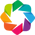

In [2]:
hv.notebook_extension('bokeh')

In [3]:
da=xr.open_dataset('../G5NR/SKEdot_merged_90x45_flip.nc')

In [4]:
SKEDOT_ANN=da.SKEDOT.mean(dim='time')
#SKEDOT_seas=da.groupby('time.season').mean(dim='time')

In [5]:
#with geoviews projection
#skedot_map=SKEDOT_ANN.to_geoimage(hover=True).redim.range(SKEDOT=(-1,1))
#with holoviews 
skedot_map=hv.QuadMesh(hv.Image(hv.Dataset(SKEDOT_ANN),kdims=['lon','lat'],vdims='SKEDOT'),kdims=['lon','lat'],vdims='SKEDOT_ANN')
skedot_map=skedot_map(plot={'width':800,'tools':['hover'],'colorbar':True,'toolbar':'above'},style={'cmap':'RdBu_r'})
skedot_map=skedot_map.redim.range(SKEDOT_ANN=(-1,1))

In [6]:
skedot_map

:QuadMesh   [lon,lat]   (SKEDOT_ANN)

In [7]:
def skedot_ts(x,y):
    if abs(x)>1000:
        #in geoviews the x,y are distances in meters
        lon,lat=G5NR_utils.merc_dist2lonlat(x,y)
    else:
        lon,lat=x,y
    SKEDOT=da.SKEDOT.sel(lat=lat,lon=lon,method='nearest')
    #skedot_curve=hv.Points(hv.Dataset(SKEDOT),kdims=['time'],group='SKEDOT',label="Lon "+format(lon,"0.1f")+" Lat "+format(lat,"0.1f"))
    skedot_points=hv.Points((SKEDOT.time,SKEDOT.values),kdims=['time','SKEDOT'],label="Lon "+format(lon,"0.1f")+" Lat "+format(lat,"0.1f")) #,kdims=['time'],group='SKEDOT') #,label="Lon "+format(lon,"0.1f")+" Lat "+format(lat,"0.1f"))
    return skedot_points(plot={'width':800,'tools':['hover','tap']})

In [8]:
%%opts Points {+framewise}
tap_latlon=streams.SingleTap(source=skedot_map,x=0,y=0)
skedot_ts_plot=hv.DynamicMap(skedot_ts,kdims=[],streams=[tap_latlon])

In [9]:
selection_time = streams.Selection1D(source=skedot_ts_plot)
def quick_look(time_index,lon_dist,lat_dist):
    if isinstance(time_index,list) and len(time_index)==0:
        ti=0
    else:
        ti=time_index[0] if len(time_index)>1 else time_index[0]
    t=da.time.isel(time=ti).values
    tstr=t.astype(str)
    yyyymmddhhmm=tstr[0:4]+tstr[5:7]+tstr[8:10]+tstr[11:13]+tstr[14:16]
    if abs(lon_dist)>1000:
        lon,lat=G5NR_utils.merc_dist2lonlat(lon_dist,lat_dist)
    else:
        lon,lat=lon_dist,lat_dist
    img=G5NR_utils.G5NR_image('cyclones',yyyymmddhhmm,lon,lat,dlat=10,dlon=20,geoviews=True)
    return img(plot={'width':800})
ql_image=hv.DynamicMap(quick_look,kdims=[],streams=[selection_time.rename(index='time_index'),tap_latlon.rename(x='lon_dist',y='lat_dist')])

In [10]:
(skedot_map+skedot_ts_plot(plot={'width':800})+ql_image).cols(1)

:Layout
   .QuadMesh.I    :QuadMesh   [lon,lat]   (SKEDOT_ANN)
   .DynamicMap.I  :DynamicMap   []
   .DynamicMap.II :DynamicMap   []